<a href="https://colab.research.google.com/github/slava-ugolnikov/KG_practice_2025/blob/main/colab/NER_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NER: LLM approach

In [1]:
!pip install openai==0.28

In [2]:
!pip install opendatasets

In [3]:
!pip install svgling

In [4]:
import json
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import opendatasets as od
import openai
import os
import pandas as pd
import re
import requests
import spacy
import time

from io import StringIO
from itertools import combinations
from sklearn.metrics import precision_score, recall_score, f1_score
from spacy import displacy
from spacy.training import offsets_to_biluo_tags, biluo_to_iob

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Dataset

CoNLL-2003 is a dataset designed for NER.

The English data was taken from the Reuters Corpus. This corpus consists of Reuters news stories between August 1996 and August 1997.

In [5]:
od.download(
    "https://www.kaggle.com/datasets/alaakhaled/conll003-englishversion/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: slavaugolnikov
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alaakhaled/conll003-englishversion


In [6]:
conll = open('/content/conll003-englishversion/train.txt', 'r').read()
conll[:160]

'-DOCSTART- -X- -X- O\n\nEU NNP B-NP B-ORG\nrejects VBZ B-VP O\nGerman JJ B-NP B-MISC\ncall NN I-NP O\nto TO B-VP O\nboycott VB I-VP O\nBritish JJ B-NP B-MISC\nlamb NN I-'

As we can see the dataset is presented in a text format so let us write the function that would convert dataset from text to a more convenient datatype (nested datatype).

In [7]:
def load_sentences(filepath):
    final = []
    sentences = []

    with open(filepath, 'r') as f:
        for line in f.readlines():
            if line == '-DOCSTART- -X- -X- O\n' or line == '\n':
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))

    return final

The dataset is already divided into train, validation and test samples.

In [8]:
conll_train = load_sentences('/content/conll003-englishversion/train.txt')
conll_test = load_sentences('/content/conll003-englishversion/test.txt')
conll_valid = load_sentences('/content/conll003-englishversion/valid.txt')

In [10]:
samples = conll_train + conll_test

schema = sorted({tag for sentence in samples for _, tag in sentence})
schema

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

BIO-разметка
* B - начало сущности
* I - сущность внутри (вторая подряд именованная сущность, относящаяся к предыдущей)
* O - не сущность
------
* LOC - место
* ORG - организация
* PER - человек
* MISC - разное


Let's look what's inside conll_train

In [11]:
print(*conll_train[0])

('EU', 'B-ORG') ('rejects', 'O') ('German', 'B-MISC') ('call', 'O') ('to', 'O') ('boycott', 'O') ('British', 'B-MISC') ('lamb', 'O') ('.', 'O')


Then we would apply this to make a DataFrame.

In [12]:
rows = []

for i, sentence in enumerate(conll_train):
    for word, label in sentence:
        rows.append({"Sentence_ID": i, "Entity": word, "Label": label})

df_conll = pd.DataFrame(rows)
df_conll.iloc[43:73]

,Sentence_ID,Entity,Label
43,4,Germany,B-LOC
44,4,'s,O
45,4,representative,O
46,4,to,O
47,4,the,O
48,4,European,B-ORG
49,4,Union,I-ORG
50,4,'s,O
51,4,veterinary,O
52,4,committee,O


In [13]:
df_conll.iloc[:20]

,Sentence_ID,Entity,Label
0,0,EU,B-ORG
1,0,rejects,O
2,0,German,B-MISC
3,0,call,O
4,0,to,O
5,0,boycott,O
6,0,British,B-MISC
7,0,lamb,O
8,0,.,O
9,1,Peter,B-PER


## Task description

An objective of this work is to conduct NER task using NLTK and SpaCy. Firstly, the sentences would be tokenized, then tokens would be annotated by PoS and then we would be able to recognize NE.

After that, a knowledge graph would be built to visualize relations between named entities.

But for subsequent prompting annotation we need just text so let's derive it.

In [14]:
rows[0]

{'Sentence_ID': 0, 'Entity': 'EU', 'Label': 'B-ORG'}

In [15]:
sentences1 = df_conll.groupby('Sentence_ID')['Entity'].apply(lambda x: ' '.join(x)).tolist()
rows_id = [i for i in range(1, len(sentences1))]
sentences = list(zip(rows_id, sentences1))
sentences[:5]

[(1, 'EU rejects German call to boycott British lamb .'),
 (2, 'Peter Blackburn'),
 (3, 'BRUSSELS 1996-08-22'),
 (4,
  'The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .'),
 (5,
  "Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer .")]

## LLM

We would use meta-llama/Llama-3-8b-chat-hf model.

Details: https://api.together.ai/models/meta-llama/Llama-3-8b-chat-hf

Meta developed and released the Meta Llama 3 family of large language models (LLMs), a collection of pretrained and instruction tuned generative text models in 8 and 70B sizes. The Llama 3 instruction tuned models are optimized for dialogue use cases and outperform many of the available open source chat models on common industry benchmarks. Further, in developing these models, we took great care to optimize helpfulness and safety

Let's use my API key.

In [16]:
openai.api_key = "<your key>"
openai.api_base = "https://api.together.xyz/v1"

Then we'll write function that is a prompt.

In [17]:
def ner_llama(sentences, save_dir="ner_results", batch_id=0):
    os.makedirs(save_dir, exist_ok=True)

    prompt = f"""You've got a task.

    Find all named entities in the following sentence using the BIO tagging format:

    - Allowed labels: "B-LOC", "B-MISC", "B-ORG", "B-PER", "I-LOC", "I-MISC", "I-ORG", "I-PER", "O".
    - Where:
      - B- = beginning of an entity
      - I- = inside an entity
      - O = outside any entity
    - Entity types:
      - PERS — person
      - LOC — location
      - ORG — organization
      - MISC — miscellaneous
    For example George Bush would be tagged like that: George (B-PER) Bush (I-PER) - single word per entity strictly.

    Notice that you should label not only entites, you should use 'O' label for words that are not named entities (they can be any part of speech: verbs, prepositions) and include them please in your output.
    Also it is very important that sentences that starts with different numbers are separated. To remember it, include the number of sentence in the output.

    Example of an output:
    Sentence 1: EU rejects German call to boycott British lamb;
    Entities: ('EU', 'B-ORG') ('rejects', 'O') ('German', 'B-MISC') ('call', 'O') ('to', 'O') ('boycott', 'O') ('British', 'B-MISC') ('lamb', 'O') ('.', 'O').

    Sentence: "{sentences}"
    """

    for i, sentence in enumerate(sentences, 1):
        prompt += f"{i}. {sentence}\n"
    prompt += "\nAnswer:\n"

    response = openai.ChatCompletion.create(
        model="meta-llama/Llama-3-8b-chat-hf",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens=2048
    )

    output = response["choices"][0]["message"]["content"]

    try:
        parsed = json.loads(output)
    except json.JSONDecodeError:
        parsed = output

    filename = os.path.join(save_dir, f"batch_{batch_id}.json")
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(parsed, f, ensure_ascii=False, indent=2)

    return parsed

Let's implement our function with the batch size value of 20.

In [21]:
batch_size = 20

for i in range(0, len(sentences), batch_size):
    batch = sentences[i:i+batch_size]
    ner_llama(batch, save_dir="ner_results", batch_id=i//batch_size)

Let's see what we've got.

In [23]:
with open("/content/drive/MyDrive/ner_prompting/batch_0.json", "r", encoding="utf-8") as f:
    data = json.load(f)
data

'Here is the output:\n\nSentence 1: (1, \'EU rejects German call to boycott British lamb .\')\nEntities: (\'EU\', \'B-ORG\') (\'rejects\', \'O\') (\'German\', \'B-MISC\') (\'call\', \'O\') (\'to\', \'O\') (\'boycott\', \'O\') (\'British\', \'B-MISC\') (\'lamb\', \'O\') (\'.\', \'O\')\n\nSentence 2: (2, \'Peter Blackburn\')\nEntities: (\'Peter\', \'B-PER\') (\'Blackburn\', \'I-PER\') (\'.\', \'O\')\n\nSentence 3: (3, \'BRUSSELS 1996-08-22\')\nEntities: (\'BRUSSELS\', \'B-LOC\') (\'1996-08-22\', \'O\')\n\nSentence 4: (4, \'The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .\')\nEntities: (\'The\', \'O\') (\'European\', \'B-ORG\') (\'Commission\', \'I-ORG\') (\'said\', \'O\') (\'on\', \'O\') (\'Thursday\', \'O\') (\'it\', \'O\') (\'disagreed\', \'O\') (\'with\', \'O\') (\'German\', \'B-MISC\') (\'advice\', \'O\') (\'to\', \'O\') (\'consumers\', \'O\') (\'

After that, we would concatenate all the texts into one.

In [24]:
folder_path = '/content/drive/MyDrive/ner_prompting/'

json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

texts = []

for file_name in json_files:
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        text = json.dumps(data, ensure_ascii=False)
        texts.append(text)

Let's check the last one dozen of texts.

In [25]:
texts[-1]

'"Here is the output:\\n\\nSentence 1: (6061, \'- Foreign Minister Levy to visit Egypt soon .\')\\nEntities: (\'Foreign\', \'O\') (\'Minister\', \'B-PER\') (\'Levy\', \'I-PER\') (\'to\', \'O\') (\'visit\', \'O\') (\'Egypt\', \'B-LOC\') (\'soon\', \'O\') (\'.\', \'O\')\\n\\nSentence 2: (6062, \'MAARIV\')\\nEntities: (\'MAARIV\', \'B-MISC\')\\n\\nSentence 3: (6063, \'- Palestinian Authority has taken over education in East Jerusalem .\')\\nEntities: (\'Palestinian\', \'B-MISC\') (\'Authority\', \'B-ORG\') (\'East\', \'O\') (\'Jerusalem\', \'B-LOC\') (\'.\', \'O\')\\n\\nSentence 4: (6064, \'- Syrian armoured columns on the move in Lebanon .\')\\nEntities: (\'Syrian\', \'B-MISC\') (\'Lebanon\', \'B-LOC\') (\'.\', \'O\')\\n\\nSentence 5: (6065, \\"- Shimon Peres to Morocco , will stay at king \'s private residence .\\")\\nEntities: (\'Shimon\', \'B-PER\') (\'Peres\', \'I-PER\') (\'to\', \'O\') (\'Morocco\', \'B-MISC\') (\'will\', \'O\') (\'stay\', \'O\') (\'at\', \'O\') (\'king\', \'O\') (\

Let's proceed to creating a dictionary of sentences and their NE to further create a dataframe.

In [44]:
pattern = r"Entities: ((?:\('.*?', '.*?'\) ?)+)"

entity_dict = {}
counter = 1

for text in texts:
    matches = re.findall(pattern, text)
    for entities_raw in matches:
        entities = re.findall(r"\('(.*?)', '(.*?)'\)", entities_raw)
        named_entities = [(word, label) for word, label in entities]
        entity_dict[counter] = named_entities
        counter += 1

In [62]:
print(entity_dict[3241])

[('Its', 'O'), ('workers', 'O'), ('are', 'O'), ('staging', 'O'), ('protests', 'O'), ('in', 'O'), ('the', 'O'), ('town', 'B-LOC'), ('s', 'I-LOC'), ('main', 'O'), ('square', 'O'), ('demanding', 'O'), ('June', 'O'), ('and', 'O'), ('July', 'O'), ('wages', 'O'), ('and', 'O'), ('last', 'O'), ('year', 'O'), ("\\\\'s", 'I-LOC'), ('holiday', 'O'), ('pay', 'O'), ('.', 'O')]


Creating dataframe.

In [46]:
rows = []

for sentence_id, entities in entity_dict.items():
    for entity, label in entities:
        rows.append({
            'Sentence_id': sentence_id,
            'Entity': entity,
            'Label': label
        })

df = pd.DataFrame(rows)

In [48]:
df

,Sentence_id,Entity,Label
0,1,Clinton,B-PER
1,1,Sunday,O
2,1,West Virginia,B-LOC
3,1,Kentucky,B-LOC
4,1,Ohio,B-LOC
...,...,...,...
87015,11216,held,O
87016,11216,this,O
87017,11216,coming,O
87018,11216,week,O


In [112]:
df[df['Sentence_id'] == 1]

,Sentence_id,Entity,Label
0,1,Clinton,B-PER
1,1,Sunday,O
2,1,West Virginia,B-LOC
3,1,Kentucky,B-LOC
4,1,Ohio,B-LOC
5,1,Michigan,B-LOC
6,1,Indiana,B-LOC
7,1,Chicago,B-LOC
8,1,.,O


Cleaning DataFrame.

In [102]:
allowed_labels = ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']
invalid_rows = df[~df["Label"].isin(allowed_labels)]
df = df.drop(invalid_rows.index)

In [103]:
df.Label.unique()

array(['B-PER', 'O', 'B-LOC', 'B-ORG', 'B-MISC', 'I-MISC', 'I-PER',
       'I-ORG', 'I-LOC'], dtype=object)

## SpaCy

This model has been already observed in ML method notebook, therefore if additional information is needed, you can look it up there.

Let's proceed to SpaCy and its pre-trained pipeline en_core_web_sm that is able to perform relation exrtaction.

In [104]:
nlp = spacy.load("en_core_web_sm")

Let's annotate our sentences with NE and their relations.

In [106]:
bio_tokens = list(zip(df.Entity, df.Label))

tokens = [token for token, _ in bio_tokens]
sentence = " ".join(tokens)

entities = []
current_entity = []
start_idx = None

for idx, (token, tag) in enumerate(bio_tokens):
    if tag.startswith("B-"):
        if current_entity:
            entities.append((start_idx, idx - 1))
        current_entity = [token]
        start_idx = idx
    elif tag.startswith("I-") and current_entity:
        current_entity.append(token)
    else:
        if current_entity:
            entities.append((start_idx, idx - 1))
            current_entity = []
            start_idx = None

if current_entity:
    entities.append((start_idx, len(bio_tokens) - 1))

doc = nlp(sentence)

# 4. Преобразуем индексы из BIO в spaCy токены (предполагается что токены совпадают)
spacy_entities = [doc[start:end+1] for start, end in entities]

# 5. Извлечение отношений между сущностями
triplets = []
for ent1, ent2 in combinations(spacy_entities, 2):
    # выделим промежуток между сущностями
    if ent1.end < ent2.start:
        span = doc[ent1.end:ent2.start]
    elif ent2.end < ent1.start:
        span = doc[ent2.end:ent1.start]
    else:
        continue  # пересекаются или совпадают

    for token in span:
        if token.dep_ in ('ROOT', 'relcl', 'attr', 'prep', 'agent', 'nsubj', 'dobj'):
            triplets.append((ent1.text, token.lemma_, ent2.text))
            break

# 6. Вывод
print("Восстановленное предложение:")
print(sentence)

print("\nСущности:")
for span in spacy_entities:
    print(span.text)

print("\nОтношения:")
for subj, rel, obj in triplets:
    print(f"({subj}) -[{rel}]-> ({obj})")


KeyboardInterrupt: 

And look inside.

In [ ]:
for doc in docs[:5]:
    print(doc[0])
    print(doc[1].ents)
    print(doc[2])

After that, we would continue with creating a whole DataFrame using the attributes of en_core_web_sm annotation.

In [ ]:
entities_doc = []
labels_doc = []
description = []
start_position = []
end_position = []
sentence_id = []

for doc in docs:
    for ents in doc[1].ents:
        sentence_id.append(doc[0])
        entities_doc.append(ents)
        labels_doc.append(ents.label_)
        description.append(spacy.explain(ents.label_))
        start_position.append(ents.start_char)
        end_position.append(ents.end_char)

ner_spacy = list(zip(sentence_id, entities_doc, labels_doc, description, start_position, end_position))
df_spacy = pd.DataFrame(ner_spacy)
df_spacy.columns = ['Sentence_ID', 'Entity', 'Label', 'Description', 'Starting Position', 'Ending Position']
df_spacy.head()

## Data Visualisation

At first, we should extract triplets from the dataframe.

In [ ]:
triplets = list(df_LLM[['Sentence_ID', 'Entity_1', 'Relation', 'Entity_2']].itertuples(index=False, name=None))
df_triplets = pd.DataFrame(triplets, columns=[['Sentence_ID', 'Entity_1', 'Relation', 'Entity_2']])
df_triplets.iloc[:10]

,Sentence_ID,Entity_1,Relation,Entity_2
0,541,Siauliai,B-LOC') ('Kareda,O
1,541,Siauliai,I-LOC') ('Lithuania,B-LOC
2,541,Kareda,NaN,NaN
3,541,Siauliai,B-LOC') ('Kareda,O
4,541,Siauliai,I-LOC') ('Lithuania,B-LOC
5,541,Lithuania,NaN,NaN
6,541,Sion,NaN,NaN
7,542,Switzerland,NaN,NaN
8,543,Attendance,NaN,NaN
9,543,"5,000",NaN,NaN


In [ ]:
df_filtered = df_triplets.iloc[24:36]

G = nx.DiGraph()

for _, row in df_filtered.iterrows():
    G.add_edge(row['Entity_1'], row['Entity_2'], label=row['Relation'])

Let's build a Knowledge graph

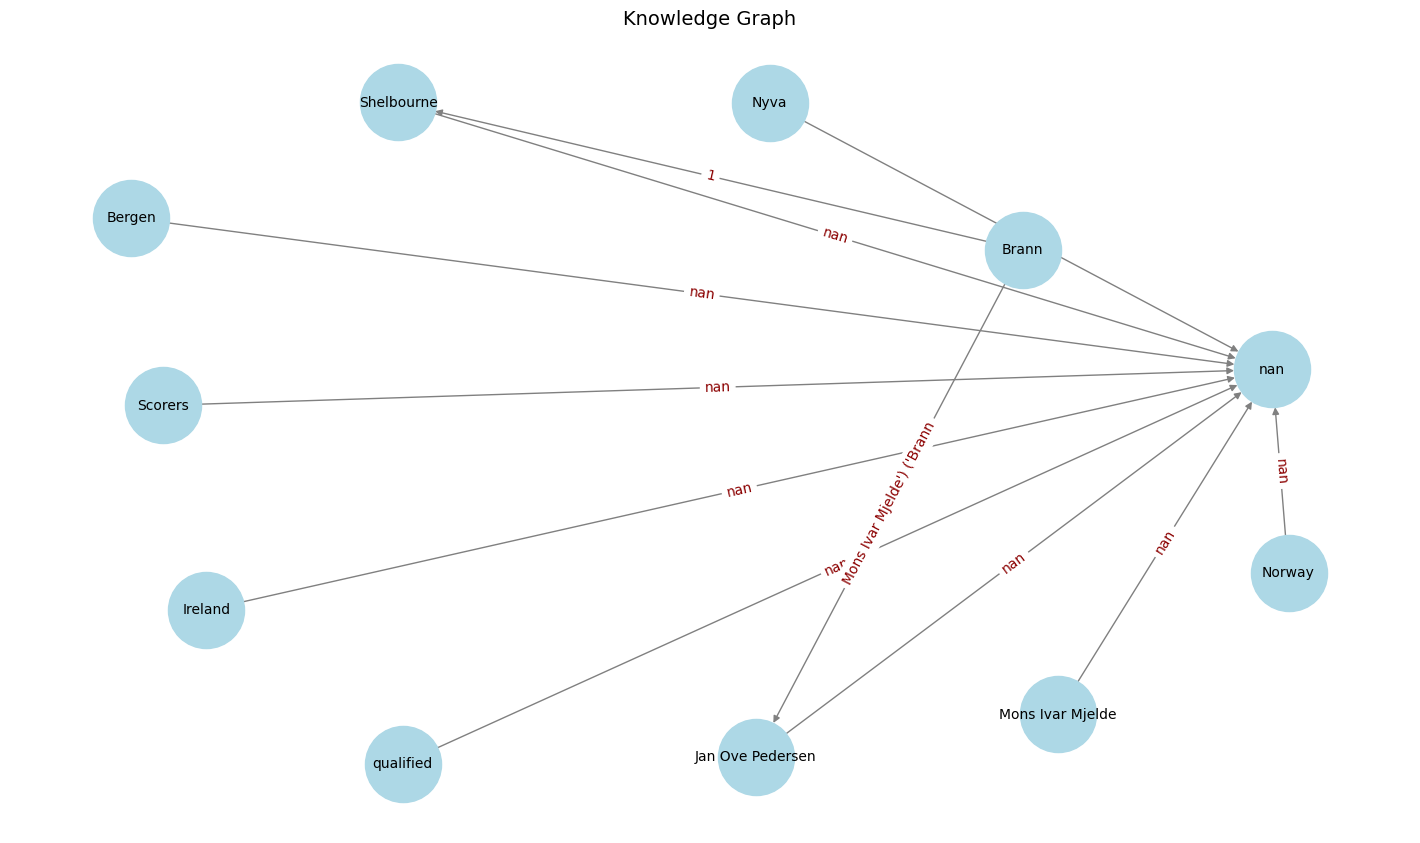

In [ ]:
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G, k=2.0, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, edge_color='gray', arrows=True)

edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkred')

plt.title("Knowledge Graph", fontsize=14)
plt.axis('off')
plt.show()

In [ ]:
texts[0]

'"Here are the answers:\\n\\n**Task 1: Named Entity Recognition**\\n\\nSentence 1: (541, \'In Siauliai : Kareda Siauliai ( Lithuania ) 0 Sion\')\\n\\nEntities: (\'Siauliai\', \'B-LOC\') (\'Kareda\', \'O\') (\'Siauliai\', \'I-LOC\') (\'Lithuania\', \'B-LOC\') (\'Sion\', \'O\')\\n\\nSentence 2: (542, \'( Switzerland ) 0\')\\n\\nEntities: (\'Switzerland\', \'B-MISC\')\\n\\nSentence 3: (543, \'Attendance : 5,000\')\\n\\nEntities: (\'Attendance\', \'O\') (\'5,000\', \'O\')\\n\\nSentence 4: (544, \'Sion win 4-2 on agrregate .\')\\n\\nEntities: (\'Sion\', \'O\') (\'win\', \'O\') (\'4-2\', \'O\')\\n\\nSentence 5: (545, \'In Vinnytsya :\')\\n\\nEntities: (\'Vinnytsya\', \'B-LOC\')\\n\\nSentence 6: (546, \'Nyva Vinnytsya ( Ukraine ) 1 Tallinna Sadam ( Estonia ) 0 ( 0-0 )\')\\n\\nEntities: (\'Nyva\', \'O\') (\'Vinnytsya\', \'I-LOC\') (\'Ukraine\', \'B-MISC\') (\'Tallinna Sadam\', \'O\') (\'Estonia\', \'B-MISC\')\\n\\nSentence 7: (547, \'Attendance : 3,000\')\\n\\nEntities: (\'Attendance\', \'O\')

## Classification metrics

To evaluate classification metrics we have got to relabel spacy's annotation for it to be identical with CoNLL's one. We will begin with creating a new dataframe on previous spacy's dataframe basis. It exploits offsets_to_biluo_tags and then biluo_to_iob methods to get BIO-annotation that is used in initial CoNLL dataset.

In [115]:
df_LLM = df

In [117]:
df_LLM.Label.unique()

array(['B-PER', 'O', 'B-LOC', 'B-ORG', 'B-MISC', 'I-MISC', 'I-PER',
       'I-ORG', 'I-LOC'], dtype=object)

In [118]:
df_conll.Label.unique()

array(['B-ORG', 'O', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG',
       'I-MISC', 'I-LOC'], dtype=object)

All annotations are correspondent.

Let's merge the datasets and find the metrics.

In [124]:
df_LLM = df_LLM.rename(columns={'Label': 'Label_LLM', 'Sentence_id': 'Sentence_ID'})

In [125]:
merged_df = pd.merge(df_conll, df_LLM, on=['Sentence_ID'], how='inner')

precision = precision_score(merged_df['Label'], merged_df['Label_LLM'], average='weighted')
recall = recall_score(merged_df['Label'], merged_df['Label_LLM'], average='weighted')
f1 = f1_score(merged_df['Label'], merged_df['Label_LLM'], average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

Precision: 0.6866
Recall: 0.6534
F1: 0.6691
